In [1]:
import os

import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, mean_absolute_error,
                             normalized_mutual_info_score, r2_score,
                             silhouette_score)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

name = "Huber_latest2"

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from VAE_GDSC import GDSCDataset, GeneDrugVAE

In [3]:
cellline = pd.read_csv(
    "../dataset/gdsc/cellline_info.csv.gz",
    usecols=["COSMIC_ID", "SMILES", "NAME", "Z_score"],
)
exp = pd.read_csv("../dataset/gdsc/exp.csv.gz", index_col=0)

In [4]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
smiles_list = cellline["SMILES"].unique().tolist()

inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [6]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [7]:
exp.index = exp.index.astype(str)
cellline["COSMIC_ID"] = cellline["COSMIC_ID"].astype(str)
drugs.index = drugs.index.astype(str)

In [8]:
exp_values = exp.to_numpy(dtype=np.float32)
cid_to_row = {cid: i for i, cid in enumerate(exp.index)}
drug_vec = {s: drugs.loc[s].to_numpy(dtype=np.float32) for s in drugs.index}
mask = cellline["COSMIC_ID"].isin(exp.index) & cellline["SMILES"].isin(drugs.index)
cellline_small = cellline.loc[mask].reset_index(drop=True)
print(f"usable pairs: {len(cellline_small):,} / {len(cellline):,}")

usable pairs: 284,826 / 284,826


In [9]:
print("n_sample:", cellline_small.shape[0])

n_sample: 284826


In [10]:
batch_size = 16384
num_epochs = 100

rec_w = 0.14  # 0.15→0.14：再構成をもう一段弱め、z活用を促進
lam = 2.65  # 2.8→2.65：分散の膨らみをさらに抑制
beta_max = 1.05  # 据え置き：後半のKL過多を軽く抑える“保険”
gamma = 2.6  # 据え置き

C_max = 0.080  # 0.075→0.080：KLの目標を少し引き上げる
C_steps = 300  # 260→300：C到達をより滑らかに（終盤の安定）

lr = 1e-3
weight_decay = 8e-4  # 据え置き：表現力を少し解放

In [11]:
ds = GDSCDataset(
    cellline_small,
    exp_values,
    cid_to_row,
    drug_vec,
    dtype=torch.float32,
    pin_memory=True,
    copy_arrays=False,
    #     materialize="none",    # ← これが重要！前展開を完全禁止
    #     ram_limit_gb=0.5       # （任意）auto を使う時の安全枠も小さくできる
)

In [12]:
val_ratio = 0.2
n_total = len(ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# 再現性
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=g)

In [13]:
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,  # GPU メモリに合わせて調整（8k〜32k 目安）
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

In [14]:
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,  # 余裕があれば少し大きめ
    shuffle=False,  # 検証はシャッフル不要
    num_workers=1,  # ここは少なめでもOK
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=False,
)

In [15]:
gene_dim = exp_values.shape[1]
smiles_dim = 768

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
device_type = (
    "cuda" if device.type == "cuda" else ("mps" if device.type == "mps" else "cpu")
)

use_amp = device_type in ("cuda", "mps")

# GradScaler は CUDA のみ
scaler = torch.amp.GradScaler(enabled=(device_type == "cuda"))

In [16]:
os.makedirs("models/gdsc", exist_ok=True)

best_val = float("inf")
best_path = f"models/gdsc/gdsc_best_{name}.pt"

# --- logs / histories ---
train_hist, val_hist, elbo_val_hist = [], [], []
train_rec_hist, train_kl_hist, train_z_hist = [], [], []
val_rec_hist, val_kl_hist, val_z_hist = [], [], []
train_capgap_hist, val_capgap_hist, C_values = [], [], []

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)

# 1) Optimizer を param group で作り直し
head_params = list(model.head.parameters())
base_params = [p for n, p in model.named_parameters() if not n.startswith("head.")]

opt = torch.optim.Adam(
    [
        {"params": base_params, "lr": lr, "weight_decay": 1e-3},
        {"params": head_params, "lr": lr * 0.5, "weight_decay": 5e-3},  # ← LR↓, WD↑
    ]
)


def _avg(sum_val, cnt):
    return sum_val / max(cnt, 1)


beta_warmup_epochs = int(0.5 * num_epochs)
for ep in range(num_epochs):
    # === 追加：このepochのβ（0→1に線形） ===
    beta = beta_max * min(1.0, (ep + 1) / beta_warmup_epochs)

    model.train()
    C = C_max * (ep / C_steps) if ep < C_steps else C_max
    C_values.append(C)

    # ---- training ----
    m_total = n_batches = 0
    rec_sum = kl_sum = z_sum = capgap_sum = 0.0
    n_train_samples = 0

    for bidx, (xg, xd, y) in enumerate(
        tqdm(train_dl, desc=f"Train E{ep+1}", leave=False)
    ):
        if ep == 0 and bidx == 0:
            print(
                f"[LR] base={opt.param_groups[0]['lr']:.2e} | head={opt.param_groups[1]['lr']:.2e}"
            )

        xg = xg.to(device, non_blocking=True)
        xd = xd.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=use_amp):
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)
            gap_sq = (kl - C) ** 2
            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss

        if device_type == "cuda":
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)  # ← これを追加してからクリップ
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xg.size(0)
        m_total += loss.item()
        n_batches += 1
        rec_sum += rec.item() * bs
        kl_sum += kl.item() * bs
        z_sum += zloss.item() * bs
        capgap_sum += gap_abs.item() * bs
        n_train_samples += bs

    train_loss = m_total / n_batches
    train_hist.append(train_loss)
    train_rec_hist.append(_avg(rec_sum, n_train_samples))
    train_kl_hist.append(_avg(kl_sum, n_train_samples))
    train_z_hist.append(_avg(z_sum, n_train_samples))
    train_capgap_hist.append(_avg(capgap_sum, n_train_samples))

    # ---- validation ----
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    v_rec_sum = v_kl_sum = v_z_sum = v_capgap_sum = 0.0
    n_val_samples = 0
    elbo_val_sum = 0.0

    with torch.no_grad():
        for xg, xd, y in val_dl:
            xg, xd, y = xg.to(device), xd.to(device), y.to(device)
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)  # ← 追加：ログ用
            gap_sq = (kl - C) ** 2  # ← 追加：損失用（二乗）

            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss
            elbo_loss = rec + beta * kl + lam * zloss

            bs = xg.size(0)
            val_loss_sum += loss.item()
            n_val_batches += 1
            v_rec_sum += rec.item() * bs
            v_kl_sum += kl.item() * bs
            v_z_sum += zloss.item() * bs
            v_capgap_sum += gap_abs.item() * bs  # ← 置換：capgap → gap_abs
            n_val_samples += bs
            elbo_val_sum += elbo_loss.item() * bs

    val_loss = val_loss_sum / n_val_batches
    val_hist.append(val_loss)
    val_rec_hist.append(_avg(v_rec_sum, n_val_samples))
    val_kl_hist.append(_avg(v_kl_sum, n_val_samples))
    val_z_hist.append(_avg(v_z_sum, n_val_samples))
    val_capgap_hist.append(_avg(v_capgap_sum, n_val_samples))
    elbo_val_hist.append(_avg(elbo_val_sum, n_val_samples))

    print(
        f"Epoch {ep+1}/{num_epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | Val(ELBO) {elbo_val_hist[-1]:.4f}"
    )

    print(
        f"  C={C:.3f} | "
        f"KL tr/val={train_kl_hist[-1]:.4f}/{val_kl_hist[-1]:.4f} | "
        f"gap(|KL-C|) tr/val={train_capgap_hist[-1]:.4f}/{val_capgap_hist[-1]:.4f} | "
        f"zloss tr/val={train_z_hist[-1]:.4f}/{val_z_hist[-1]:.4f} | "
        f"rec tr/val={train_rec_hist[-1]:.4f}/{val_rec_hist[-1]:.4f} | "
        f"beta={beta:.4f}, gamma={gamma:.4f}"
    )

    if (ep + 1) % 10 == 0:
        model.eval()
        eval_dl = torch.utils.data.DataLoader(
            val_ds,
            batch_size=8192,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            persistent_workers=False,
            drop_last=False,
        )
        ys, yhats = [], []
        with torch.inference_mode():
            for xg, xd, y in eval_dl:
                xg, xd = xg.to(device), xd.to(device)
                _, _, _, yhat = model(xg, xd)
                ys.append(y.cpu().numpy())
                yhats.append(yhat.cpu().numpy())
        import numpy as np
        from sklearn.metrics import mean_absolute_error, r2_score

        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        mae = mean_absolute_error(ys, yhats)
        r2 = r2_score(ys, yhats)
        print(f"  [Eval@E{ep+1}] MAE={mae:.4f}, R^2={r2:.4f}")
        print(f"  [Eval@E{ep+1}] yhat mean/std = {yhats.mean():.4f}/{yhats.std():.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"[Save] Best model updated at epoch {ep+1}: {best_path}")

Train E1:   0%|          | 0/13 [00:00<?, ?it/s]

[LR] base=1.00e-03 | head=5.00e-04


Epoch 1/100 | Train 1.2553 | Val 1.2054 | Val(ELBO) 2.0726
  C=0.000 | KL tr/val=0.0900/0.0554 | gap(|KL-C|) tr/val=0.0900/0.0554 | zloss tr/val=0.4055/0.3981 | rec tr/val=1.0342/1.0165 | beta=0.0210, gamma=2.6000
[Save] Best model updated at epoch 1: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 2/100 | Train 1.1688 | Val 1.1394 | Val(ELBO) 1.9925
  C=0.000 | KL tr/val=0.0695/0.0654 | gap(|KL-C|) tr/val=0.0692/0.0651 | zloss tr/val=0.3817/0.3719 | rec tr/val=1.0091/1.0042 | beta=0.0420, gamma=2.6000
[Save] Best model updated at epoch 2: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 3/100 | Train 1.1067 | Val 1.0861 | Val(ELBO) 1.9308
  C=0.001 | KL tr/val=0.0841/0.0804 | gap(|KL-C|) tr/val=0.0836/0.0798 | zloss tr/val=0.3557/0.3490 | rec tr/val=1.0021/1.0008 | beta=0.0630, gamma=2.6000
[Save] Best model updated at epoch 3: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 4/100 | Train 1.0671 | Val 1.0549 | Val(ELBO) 1.8996
  C=0.001 | KL tr/val=0.0816/0.0787 | gap(|KL-C|) tr/val=0.0808/0.0779 | zloss tr/val=0.3407/0.3370 | rec tr/val=1.0002/0.9999 | beta=0.0840, gamma=2.6000
[Save] Best model updated at epoch 4: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 5/100 | Train 1.0382 | Val 1.0377 | Val(ELBO) 1.8876
  C=0.001 | KL tr/val=0.0705/0.0636 | gap(|KL-C|) tr/val=0.0695/0.0625 | zloss tr/val=0.3314/0.3325 | rec tr/val=0.9998/0.9998 | beta=0.1050, gamma=2.6000
[Save] Best model updated at epoch 5: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 6/100 | Train 1.0254 | Val 1.0323 | Val(ELBO) 1.8872
  C=0.001 | KL tr/val=0.0595/0.0471 | gap(|KL-C|) tr/val=0.0582/0.0457 | zloss tr/val=0.3279/0.3327 | rec tr/val=0.9998/0.9997 | beta=0.1260, gamma=2.6000
[Save] Best model updated at epoch 6: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 7/100 | Train 1.0173 | Val 1.0253 | Val(ELBO) 1.8786
  C=0.002 | KL tr/val=0.0516/0.0493 | gap(|KL-C|) tr/val=0.0500/0.0477 | zloss tr/val=0.3257/0.3289 | rec tr/val=0.9997/0.9997 | beta=0.1470, gamma=2.6000
[Save] Best model updated at epoch 7: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 8/100 | Train 1.0081 | Val 1.0102 | Val(ELBO) 1.8640
  C=0.002 | KL tr/val=0.0485/0.0483 | gap(|KL-C|) tr/val=0.0467/0.0465 | zloss tr/val=0.3223/0.3231 | rec tr/val=0.9998/0.9997 | beta=0.1680, gamma=2.6000
[Save] Best model updated at epoch 8: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 9/100 | Train 0.9955 | Val 0.9960 | Val(ELBO) 1.8518
  C=0.002 | KL tr/val=0.0464/0.0422 | gap(|KL-C|) tr/val=0.0443/0.0401 | zloss tr/val=0.3176/0.3185 | rec tr/val=0.9995/0.9997 | beta=0.1890, gamma=2.6000
[Save] Best model updated at epoch 9: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 10/100 | Train 0.9867 | Val 0.9856 | Val(ELBO) 1.8425
  C=0.002 | KL tr/val=0.0426/0.0362 | gap(|KL-C|) tr/val=0.0402/0.0338 | zloss tr/val=0.3145/0.3152 | rec tr/val=0.9996/0.9997 | beta=0.2100, gamma=2.6000
  [Eval@E10] MAE=0.6596, R^2=0.2572
  [Eval@E10] yhat mean/std = 0.0592/0.4447
[Save] Best model updated at epoch 10: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 11/100 | Train 0.9713 | Val 0.9715 | Val(ELBO) 1.8279
  C=0.003 | KL tr/val=0.0414/0.0391 | gap(|KL-C|) tr/val=0.0387/0.0364 | zloss tr/val=0.3086/0.3091 | rec tr/val=0.9995/0.9997 | beta=0.2310, gamma=2.6000
[Save] Best model updated at epoch 11: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 12/100 | Train 0.9652 | Val 0.9766 | Val(ELBO) 1.8334
  C=0.003 | KL tr/val=0.0394/0.0379 | gap(|KL-C|) tr/val=0.0364/0.0350 | zloss tr/val=0.3063/0.3110 | rec tr/val=0.9997/0.9997 | beta=0.2520, gamma=2.6000


Epoch 13/100 | Train 0.9569 | Val 0.9626 | Val(ELBO) 1.8197
  C=0.003 | KL tr/val=0.0355/0.0335 | gap(|KL-C|) tr/val=0.0323/0.0303 | zloss tr/val=0.3036/0.3060 | rec tr/val=0.9997/0.9997 | beta=0.2730, gamma=2.6000
[Save] Best model updated at epoch 13: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 14/100 | Train 0.9525 | Val 0.9609 | Val(ELBO) 1.8174
  C=0.003 | KL tr/val=0.0351/0.0393 | gap(|KL-C|) tr/val=0.0316/0.0359 | zloss tr/val=0.3017/0.3042 | rec tr/val=0.9997/0.9997 | beta=0.2940, gamma=2.6000
[Save] Best model updated at epoch 14: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 15/100 | Train 0.9451 | Val 0.9546 | Val(ELBO) 1.8125
  C=0.004 | KL tr/val=0.0334/0.0304 | gap(|KL-C|) tr/val=0.0296/0.0266 | zloss tr/val=0.2990/0.3031 | rec tr/val=0.9997/0.9997 | beta=0.3150, gamma=2.6000
[Save] Best model updated at epoch 15: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 16/100 | Train 0.9341 | Val 0.9449 | Val(ELBO) 1.8034
  C=0.004 | KL tr/val=0.0318/0.0265 | gap(|KL-C|) tr/val=0.0278/0.0225 | zloss tr/val=0.2949/0.2999 | rec tr/val=0.9996/0.9997 | beta=0.3360, gamma=2.6000
[Save] Best model updated at epoch 16: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 17/100 | Train 0.9273 | Val 0.9384 | Val(ELBO) 1.7964
  C=0.004 | KL tr/val=0.0301/0.0273 | gap(|KL-C|) tr/val=0.0259/0.0230 | zloss tr/val=0.2924/0.2970 | rec tr/val=0.9995/0.9997 | beta=0.3570, gamma=2.6000
[Save] Best model updated at epoch 17: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 18/100 | Train 0.9462 | Val 0.9450 | Val(ELBO) 1.8035
  C=0.005 | KL tr/val=0.0278/0.0228 | gap(|KL-C|) tr/val=0.0233/0.0182 | zloss tr/val=0.2997/0.3001 | rec tr/val=0.9998/0.9997 | beta=0.3780, gamma=2.6000


Epoch 19/100 | Train 0.9250 | Val 0.9352 | Val(ELBO) 1.7929
  C=0.005 | KL tr/val=0.0276/0.0301 | gap(|KL-C|) tr/val=0.0228/0.0253 | zloss tr/val=0.2916/0.2948 | rec tr/val=0.9996/0.9997 | beta=0.3990, gamma=2.6000
[Save] Best model updated at epoch 19: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 20/100 | Train 0.9160 | Val 0.9284 | Val(ELBO) 1.7869
  C=0.005 | KL tr/val=0.0275/0.0243 | gap(|KL-C|) tr/val=0.0224/0.0193 | zloss tr/val=0.2880/0.2932 | rec tr/val=0.9995/0.9997 | beta=0.4200, gamma=2.6000
  [Eval@E20] MAE=0.6290, R^2=0.3131
  [Eval@E20] yhat mean/std = 0.0047/0.5235
[Save] Best model updated at epoch 20: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 21/100 | Train 0.9192 | Val 0.9766 | Val(ELBO) 1.8362
  C=0.005 | KL tr/val=0.0261/0.0208 | gap(|KL-C|) tr/val=0.0207/0.0154 | zloss tr/val=0.2893/0.3122 | rec tr/val=0.9997/0.9997 | beta=0.4410, gamma=2.6000


Epoch 22/100 | Train 0.9304 | Val 0.9290 | Val(ELBO) 1.7878
  C=0.006 | KL tr/val=0.0235/0.0213 | gap(|KL-C|) tr/val=0.0179/0.0157 | zloss tr/val=0.2939/0.2937 | rec tr/val=0.9997/0.9997 | beta=0.4620, gamma=2.6000


Epoch 23/100 | Train 0.9060 | Val 0.9179 | Val(ELBO) 1.7771
  C=0.006 | KL tr/val=0.0246/0.0212 | gap(|KL-C|) tr/val=0.0187/0.0153 | zloss tr/val=0.2843/0.2895 | rec tr/val=0.9996/0.9997 | beta=0.4830, gamma=2.6000
[Save] Best model updated at epoch 23: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 24/100 | Train 0.9000 | Val 0.9117 | Val(ELBO) 1.7704
  C=0.006 | KL tr/val=0.0234/0.0225 | gap(|KL-C|) tr/val=0.0173/0.0164 | zloss tr/val=0.2821/0.2865 | rec tr/val=0.9996/0.9997 | beta=0.5040, gamma=2.6000
[Save] Best model updated at epoch 24: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 25/100 | Train 0.8928 | Val 0.9046 | Val(ELBO) 1.7636
  C=0.006 | KL tr/val=0.0224/0.0208 | gap(|KL-C|) tr/val=0.0160/0.0144 | zloss tr/val=0.2794/0.2841 | rec tr/val=0.9997/0.9997 | beta=0.5250, gamma=2.6000
[Save] Best model updated at epoch 25: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 26/100 | Train 0.8850 | Val 0.9008 | Val(ELBO) 1.7601
  C=0.007 | KL tr/val=0.0215/0.0196 | gap(|KL-C|) tr/val=0.0149/0.0130 | zloss tr/val=0.2765/0.2829 | rec tr/val=0.9997/0.9997 | beta=0.5460, gamma=2.6000
[Save] Best model updated at epoch 26: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 27/100 | Train 0.8836 | Val 0.9031 | Val(ELBO) 1.7624
  C=0.007 | KL tr/val=0.0206/0.0210 | gap(|KL-C|) tr/val=0.0137/0.0141 | zloss tr/val=0.2761/0.2833 | rec tr/val=0.9995/0.9997 | beta=0.5670, gamma=2.6000


Epoch 28/100 | Train 0.8813 | Val 0.8939 | Val(ELBO) 1.7531
  C=0.007 | KL tr/val=0.0206/0.0174 | gap(|KL-C|) tr/val=0.0134/0.0102 | zloss tr/val=0.2750/0.2804 | rec tr/val=0.9998/0.9997 | beta=0.5880, gamma=2.6000
[Save] Best model updated at epoch 28: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 29/100 | Train 0.8747 | Val 0.8926 | Val(ELBO) 1.7523
  C=0.007 | KL tr/val=0.0199/0.0184 | gap(|KL-C|) tr/val=0.0124/0.0110 | zloss tr/val=0.2725/0.2798 | rec tr/val=0.9997/0.9997 | beta=0.6090, gamma=2.6000
[Save] Best model updated at epoch 29: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 30/100 | Train 0.8720 | Val 0.8891 | Val(ELBO) 1.7487
  C=0.008 | KL tr/val=0.0189/0.0188 | gap(|KL-C|) tr/val=0.0112/0.0111 | zloss tr/val=0.2716/0.2782 | rec tr/val=0.9996/0.9997 | beta=0.6300, gamma=2.6000
  [Eval@E30] MAE=0.6078, R^2=0.3512
  [Eval@E30] yhat mean/std = 0.0012/0.5878
[Save] Best model updated at epoch 30: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 31/100 | Train 0.8754 | Val 0.8910 | Val(ELBO) 1.7498
  C=0.008 | KL tr/val=0.0190/0.0187 | gap(|KL-C|) tr/val=0.0110/0.0107 | zloss tr/val=0.2727/0.2785 | rec tr/val=0.9997/0.9997 | beta=0.6510, gamma=2.6000


Epoch 32/100 | Train 0.8644 | Val 0.8787 | Val(ELBO) 1.7382
  C=0.008 | KL tr/val=0.0192/0.0170 | gap(|KL-C|) tr/val=0.0110/0.0087 | zloss tr/val=0.2684/0.2744 | rec tr/val=0.9996/0.9997 | beta=0.6720, gamma=2.6000
[Save] Best model updated at epoch 32: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 33/100 | Train 0.8572 | Val 0.8742 | Val(ELBO) 1.7340
  C=0.009 | KL tr/val=0.0185/0.0155 | gap(|KL-C|) tr/val=0.0100/0.0070 | zloss tr/val=0.2657/0.2730 | rec tr/val=0.9995/0.9997 | beta=0.6930, gamma=2.6000
[Save] Best model updated at epoch 33: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 34/100 | Train 0.8545 | Val 0.8740 | Val(ELBO) 1.7336
  C=0.009 | KL tr/val=0.0180/0.0171 | gap(|KL-C|) tr/val=0.0092/0.0083 | zloss tr/val=0.2647/0.2723 | rec tr/val=0.9998/0.9997 | beta=0.7140, gamma=2.6000
[Save] Best model updated at epoch 34: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 35/100 | Train 0.8526 | Val 0.8802 | Val(ELBO) 1.7403
  C=0.009 | KL tr/val=0.0179/0.0159 | gap(|KL-C|) tr/val=0.0088/0.0069 | zloss tr/val=0.2639/0.2750 | rec tr/val=0.9996/0.9997 | beta=0.7350, gamma=2.6000


Epoch 36/100 | Train 0.8458 | Val 0.8640 | Val(ELBO) 1.7232
  C=0.009 | KL tr/val=0.0174/0.0146 | gap(|KL-C|) tr/val=0.0081/0.0052 | zloss tr/val=0.2613/0.2689 | rec tr/val=0.9995/0.9997 | beta=0.7560, gamma=2.6000
[Save] Best model updated at epoch 36: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 37/100 | Train 0.8407 | Val 0.8679 | Val(ELBO) 1.7271
  C=0.010 | KL tr/val=0.0173/0.0150 | gap(|KL-C|) tr/val=0.0077/0.0054 | zloss tr/val=0.2593/0.2701 | rec tr/val=0.9998/0.9997 | beta=0.7770, gamma=2.6000


Epoch 38/100 | Train 0.8369 | Val 0.8641 | Val(ELBO) 1.7243
  C=0.010 | KL tr/val=0.0165/0.0156 | gap(|KL-C|) tr/val=0.0066/0.0058 | zloss tr/val=0.2580/0.2687 | rec tr/val=0.9997/0.9997 | beta=0.7980, gamma=2.6000


Epoch 39/100 | Train 0.8307 | Val 0.8560 | Val(ELBO) 1.7164
  C=0.010 | KL tr/val=0.0166/0.0153 | gap(|KL-C|) tr/val=0.0064/0.0052 | zloss tr/val=0.2555/0.2657 | rec tr/val=0.9998/0.9997 | beta=0.8190, gamma=2.6000
[Save] Best model updated at epoch 39: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 40/100 | Train 0.8305 | Val 0.8537 | Val(ELBO) 1.7134
  C=0.010 | KL tr/val=0.0160/0.0127 | gap(|KL-C|) tr/val=0.0056/0.0023 | zloss tr/val=0.2555/0.2653 | rec tr/val=0.9996/0.9997 | beta=0.8400, gamma=2.6000
  [Eval@E40] MAE=0.5897, R^2=0.3820
  [Eval@E40] yhat mean/std = 0.0629/0.5762
[Save] Best model updated at epoch 40: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 41/100 | Train 0.8266 | Val 0.8576 | Val(ELBO) 1.7170
  C=0.011 | KL tr/val=0.0161/0.0152 | gap(|KL-C|) tr/val=0.0054/0.0045 | zloss tr/val=0.2538/0.2657 | rec tr/val=0.9998/0.9997 | beta=0.8610, gamma=2.6000


Epoch 42/100 | Train 0.8281 | Val 0.8637 | Val(ELBO) 1.7235
  C=0.011 | KL tr/val=0.0168/0.0117 | gap(|KL-C|) tr/val=0.0058/0.0008 | zloss tr/val=0.2541/0.2692 | rec tr/val=0.9996/0.9997 | beta=0.8820, gamma=2.6000


Epoch 43/100 | Train 0.8244 | Val 0.8477 | Val(ELBO) 1.7074
  C=0.011 | KL tr/val=0.0160/0.0124 | gap(|KL-C|) tr/val=0.0048/0.0012 | zloss tr/val=0.2528/0.2628 | rec tr/val=0.9997/0.9997 | beta=0.9030, gamma=2.6000
[Save] Best model updated at epoch 43: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 44/100 | Train 0.8110 | Val 0.8381 | Val(ELBO) 1.6978
  C=0.011 | KL tr/val=0.0156/0.0136 | gap(|KL-C|) tr/val=0.0041/0.0021 | zloss tr/val=0.2478/0.2587 | rec tr/val=0.9995/0.9997 | beta=0.9240, gamma=2.6000
[Save] Best model updated at epoch 44: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 45/100 | Train 0.8036 | Val 0.8400 | Val(ELBO) 1.6997
  C=0.012 | KL tr/val=0.0153/0.0123 | gap(|KL-C|) tr/val=0.0035/0.0005 | zloss tr/val=0.2449/0.2598 | rec tr/val=0.9998/0.9997 | beta=0.9450, gamma=2.6000


Epoch 46/100 | Train 0.8021 | Val 0.8313 | Val(ELBO) 1.6913
  C=0.012 | KL tr/val=0.0156/0.0125 | gap(|KL-C|) tr/val=0.0037/0.0005 | zloss tr/val=0.2442/0.2564 | rec tr/val=0.9997/0.9997 | beta=0.9660, gamma=2.6000
[Save] Best model updated at epoch 46: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 47/100 | Train 0.7990 | Val 0.8361 | Val(ELBO) 1.6959
  C=0.012 | KL tr/val=0.0143/0.0120 | gap(|KL-C|) tr/val=0.0026/0.0003 | zloss tr/val=0.2434/0.2582 | rec tr/val=0.9997/0.9997 | beta=0.9870, gamma=2.6000


Epoch 48/100 | Train 0.7994 | Val 0.8348 | Val(ELBO) 1.6947
  C=0.013 | KL tr/val=0.0140/0.0108 | gap(|KL-C|) tr/val=0.0014/0.0017 | zloss tr/val=0.2435/0.2582 | rec tr/val=0.9995/0.9997 | beta=1.0080, gamma=2.6000


Epoch 49/100 | Train 0.7971 | Val 0.8273 | Val(ELBO) 1.6869
  C=0.013 | KL tr/val=0.0136/0.0118 | gap(|KL-C|) tr/val=0.0016/0.0010 | zloss tr/val=0.2427/0.2547 | rec tr/val=0.9998/0.9997 | beta=1.0290, gamma=2.6000
[Save] Best model updated at epoch 49: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 50/100 | Train 0.7882 | Val 0.8292 | Val(ELBO) 1.6888
  C=0.013 | KL tr/val=0.0131/0.0113 | gap(|KL-C|) tr/val=0.0010/0.0017 | zloss tr/val=0.2395/0.2555 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E50] MAE=0.5773, R^2=0.4111
  [Eval@E50] yhat mean/std = -0.0238/0.6212


Epoch 51/100 | Train 0.7903 | Val 0.8262 | Val(ELBO) 1.6857
  C=0.013 | KL tr/val=0.0138/0.0117 | gap(|KL-C|) tr/val=0.0013/0.0017 | zloss tr/val=0.2399/0.2542 | rec tr/val=0.9999/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 51: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 52/100 | Train 0.7855 | Val 0.8276 | Val(ELBO) 1.6868
  C=0.014 | KL tr/val=0.0146/0.0100 | gap(|KL-C|) tr/val=0.0014/0.0036 | zloss tr/val=0.2378/0.2553 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 53/100 | Train 0.7814 | Val 0.8214 | Val(ELBO) 1.6807
  C=0.014 | KL tr/val=0.0148/0.0113 | gap(|KL-C|) tr/val=0.0017/0.0026 | zloss tr/val=0.2362/0.2525 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 53: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 54/100 | Train 0.7822 | Val 0.8297 | Val(ELBO) 1.6887
  C=0.014 | KL tr/val=0.0139/0.0127 | gap(|KL-C|) tr/val=0.0024/0.0014 | zloss tr/val=0.2369/0.2550 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 55/100 | Train 0.7770 | Val 0.8214 | Val(ELBO) 1.6810
  C=0.014 | KL tr/val=0.0132/0.0124 | gap(|KL-C|) tr/val=0.0014/0.0020 | zloss tr/val=0.2352/0.2522 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 56/100 | Train 0.7691 | Val 0.8142 | Val(ELBO) 1.6739
  C=0.015 | KL tr/val=0.0133/0.0109 | gap(|KL-C|) tr/val=0.0020/0.0037 | zloss tr/val=0.2321/0.2501 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 56: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 57/100 | Train 0.7688 | Val 0.8195 | Val(ELBO) 1.6791
  C=0.015 | KL tr/val=0.0133/0.0107 | gap(|KL-C|) tr/val=0.0023/0.0043 | zloss tr/val=0.2320/0.2522 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 58/100 | Train 0.7651 | Val 0.8178 | Val(ELBO) 1.6772
  C=0.015 | KL tr/val=0.0123/0.0101 | gap(|KL-C|) tr/val=0.0029/0.0051 | zloss tr/val=0.2310/0.2517 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 59/100 | Train 0.7821 | Val 0.8269 | Val(ELBO) 1.6866
  C=0.015 | KL tr/val=0.0136/0.0107 | gap(|KL-C|) tr/val=0.0023/0.0048 | zloss tr/val=0.2369/0.2550 | rec tr/val=0.9991/0.9997 | beta=1.0500, gamma=2.6000


Epoch 60/100 | Train 0.7677 | Val 0.8175 | Val(ELBO) 1.6774
  C=0.016 | KL tr/val=0.0125/0.0116 | gap(|KL-C|) tr/val=0.0034/0.0041 | zloss tr/val=0.2319/0.2511 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E60] MAE=0.5724, R^2=0.4233
  [Eval@E60] yhat mean/std = -0.0390/0.6642


Epoch 61/100 | Train 0.7621 | Val 0.8121 | Val(ELBO) 1.6716
  C=0.016 | KL tr/val=0.0139/0.0116 | gap(|KL-C|) tr/val=0.0027/0.0044 | zloss tr/val=0.2293/0.2489 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 61: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 62/100 | Train 0.7523 | Val 0.8083 | Val(ELBO) 1.6673
  C=0.016 | KL tr/val=0.0126/0.0110 | gap(|KL-C|) tr/val=0.0040/0.0053 | zloss tr/val=0.2261/0.2476 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 62: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 63/100 | Train 0.7778 | Val 0.8173 | Val(ELBO) 1.6772
  C=0.017 | KL tr/val=0.0137/0.0109 | gap(|KL-C|) tr/val=0.0037/0.0056 | zloss tr/val=0.2353/0.2513 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 64/100 | Train 0.7552 | Val 0.8055 | Val(ELBO) 1.6642
  C=0.017 | KL tr/val=0.0142/0.0109 | gap(|KL-C|) tr/val=0.0035/0.0059 | zloss tr/val=0.2265/0.2465 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 64: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 65/100 | Train 0.7483 | Val 0.8080 | Val(ELBO) 1.6675
  C=0.017 | KL tr/val=0.0138/0.0097 | gap(|KL-C|) tr/val=0.0032/0.0074 | zloss tr/val=0.2241/0.2482 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 66/100 | Train 0.7489 | Val 0.8048 | Val(ELBO) 1.6638
  C=0.017 | KL tr/val=0.0146/0.0108 | gap(|KL-C|) tr/val=0.0040/0.0065 | zloss tr/val=0.2240/0.2463 | rec tr/val=0.9994/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 66: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 67/100 | Train 0.7465 | Val 0.8076 | Val(ELBO) 1.6663
  C=0.018 | KL tr/val=0.0148/0.0098 | gap(|KL-C|) tr/val=0.0035/0.0078 | zloss tr/val=0.2230/0.2477 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 68/100 | Train 0.7397 | Val 0.8001 | Val(ELBO) 1.6593
  C=0.018 | KL tr/val=0.0133/0.0107 | gap(|KL-C|) tr/val=0.0047/0.0072 | zloss tr/val=0.2210/0.2447 | rec tr/val=0.9994/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 68: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 69/100 | Train 0.7385 | Val 0.8128 | Val(ELBO) 1.6725
  C=0.018 | KL tr/val=0.0125/0.0110 | gap(|KL-C|) tr/val=0.0057/0.0071 | zloss tr/val=0.2209/0.2495 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 70/100 | Train 0.7427 | Val 0.8069 | Val(ELBO) 1.6663
  C=0.018 | KL tr/val=0.0138/0.0106 | gap(|KL-C|) tr/val=0.0049/0.0078 | zloss tr/val=0.2220/0.2474 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E70] MAE=0.5671, R^2=0.4337
  [Eval@E70] yhat mean/std = -0.0283/0.6754


Epoch 71/100 | Train 0.7338 | Val 0.7978 | Val(ELBO) 1.6564
  C=0.019 | KL tr/val=0.0126/0.0100 | gap(|KL-C|) tr/val=0.0060/0.0087 | zloss tr/val=0.2191/0.2439 | rec tr/val=0.9994/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 71: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 72/100 | Train 0.7328 | Val 0.8034 | Val(ELBO) 1.6625
  C=0.019 | KL tr/val=0.0126/0.0103 | gap(|KL-C|) tr/val=0.0064/0.0086 | zloss tr/val=0.2187/0.2460 | rec tr/val=1.0000/0.9997 | beta=1.0500, gamma=2.6000


Epoch 73/100 | Train 0.7314 | Val 0.8009 | Val(ELBO) 1.6598
  C=0.019 | KL tr/val=0.0134/0.0102 | gap(|KL-C|) tr/val=0.0059/0.0090 | zloss tr/val=0.2178/0.2450 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 74/100 | Train 0.7300 | Val 0.8039 | Val(ELBO) 1.6629
  C=0.019 | KL tr/val=0.0137/0.0091 | gap(|KL-C|) tr/val=0.0058/0.0103 | zloss tr/val=0.2172/0.2467 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 75/100 | Train 0.7305 | Val 0.8046 | Val(ELBO) 1.6634
  C=0.020 | KL tr/val=0.0138/0.0096 | gap(|KL-C|) tr/val=0.0060/0.0101 | zloss tr/val=0.2174/0.2466 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 76/100 | Train 0.7257 | Val 0.8076 | Val(ELBO) 1.6665
  C=0.020 | KL tr/val=0.0131/0.0103 | gap(|KL-C|) tr/val=0.0069/0.0097 | zloss tr/val=0.2158/0.2475 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 77/100 | Train 0.7271 | Val 0.7954 | Val(ELBO) 1.6551
  C=0.020 | KL tr/val=0.0126/0.0094 | gap(|KL-C|) tr/val=0.0077/0.0108 | zloss tr/val=0.2165/0.2436 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 77: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 78/100 | Train 0.7158 | Val 0.7972 | Val(ELBO) 1.6561
  C=0.021 | KL tr/val=0.0106/0.0102 | gap(|KL-C|) tr/val=0.0100/0.0104 | zloss tr/val=0.2130/0.2437 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 79/100 | Train 0.7196 | Val 0.8010 | Val(ELBO) 1.6591
  C=0.021 | KL tr/val=0.0115/0.0092 | gap(|KL-C|) tr/val=0.0093/0.0116 | zloss tr/val=0.2141/0.2452 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 80/100 | Train 0.7168 | Val 0.7986 | Val(ELBO) 1.6566
  C=0.021 | KL tr/val=0.0130/0.0097 | gap(|KL-C|) tr/val=0.0081/0.0114 | zloss tr/val=0.2125/0.2440 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E80] MAE=0.5602, R^2=0.4367
  [Eval@E80] yhat mean/std = 0.0974/0.6713


Epoch 81/100 | Train 0.7116 | Val 0.7942 | Val(ELBO) 1.6530
  C=0.021 | KL tr/val=0.0141/0.0096 | gap(|KL-C|) tr/val=0.0072/0.0118 | zloss tr/val=0.2100/0.2428 | rec tr/val=1.0000/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 81: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 82/100 | Train 0.7198 | Val 0.7994 | Val(ELBO) 1.6584
  C=0.022 | KL tr/val=0.0108/0.0095 | gap(|KL-C|) tr/val=0.0108/0.0121 | zloss tr/val=0.2144/0.2448 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 83/100 | Train 0.7153 | Val 0.7912 | Val(ELBO) 1.6497
  C=0.022 | KL tr/val=0.0137/0.0098 | gap(|KL-C|) tr/val=0.0081/0.0121 | zloss tr/val=0.2116/0.2414 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 83: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 84/100 | Train 0.7070 | Val 0.7959 | Val(ELBO) 1.6544
  C=0.022 | KL tr/val=0.0120/0.0095 | gap(|KL-C|) tr/val=0.0101/0.0127 | zloss tr/val=0.2091/0.2433 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 85/100 | Train 0.7005 | Val 0.7946 | Val(ELBO) 1.6529
  C=0.022 | KL tr/val=0.0103/0.0095 | gap(|KL-C|) tr/val=0.0121/0.0129 | zloss tr/val=0.2073/0.2427 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 86/100 | Train 0.7106 | Val 0.8020 | Val(ELBO) 1.6612
  C=0.023 | KL tr/val=0.0155/0.0098 | gap(|KL-C|) tr/val=0.0072/0.0129 | zloss tr/val=0.2092/0.2457 | rec tr/val=0.9998/0.9997 | beta=1.0500, gamma=2.6000


Epoch 87/100 | Train 0.7047 | Val 0.7872 | Val(ELBO) 1.6459
  C=0.023 | KL tr/val=0.0116/0.0096 | gap(|KL-C|) tr/val=0.0114/0.0133 | zloss tr/val=0.2084/0.2400 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 87: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 88/100 | Train 0.6972 | Val 0.7902 | Val(ELBO) 1.6492
  C=0.023 | KL tr/val=0.0127/0.0091 | gap(|KL-C|) tr/val=0.0105/0.0141 | zloss tr/val=0.2051/0.2415 | rec tr/val=0.9994/0.9997 | beta=1.0500, gamma=2.6000


Epoch 89/100 | Train 0.7054 | Val 0.7990 | Val(ELBO) 1.6567
  C=0.023 | KL tr/val=0.0128/0.0082 | gap(|KL-C|) tr/val=0.0106/0.0152 | zloss tr/val=0.2082/0.2447 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 90/100 | Train 0.7052 | Val 0.7884 | Val(ELBO) 1.6470
  C=0.024 | KL tr/val=0.0118/0.0095 | gap(|KL-C|) tr/val=0.0119/0.0142 | zloss tr/val=0.2085/0.2405 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E90] MAE=0.5567, R^2=0.4488
  [Eval@E90] yhat mean/std = 0.0213/0.6858


Epoch 91/100 | Train 0.6951 | Val 0.7846 | Val(ELBO) 1.6435
  C=0.024 | KL tr/val=0.0134/0.0091 | gap(|KL-C|) tr/val=0.0106/0.0149 | zloss tr/val=0.2040/0.2393 | rec tr/val=0.9994/0.9997 | beta=1.0500, gamma=2.6000
[Save] Best model updated at epoch 91: models/gdsc/gdsc_best_Huber_latest2.pt


Epoch 92/100 | Train 0.7081 | Val 0.7923 | Val(ELBO) 1.6505
  C=0.024 | KL tr/val=0.0158/0.0091 | gap(|KL-C|) tr/val=0.0084/0.0152 | zloss tr/val=0.2080/0.2420 | rec tr/val=0.9993/0.9997 | beta=1.0500, gamma=2.6000


Epoch 93/100 | Train 0.6924 | Val 0.7864 | Val(ELBO) 1.6449
  C=0.025 | KL tr/val=0.0132/0.0091 | gap(|KL-C|) tr/val=0.0113/0.0154 | zloss tr/val=0.2031/0.2398 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 94/100 | Train 0.6876 | Val 0.7868 | Val(ELBO) 1.6459
  C=0.025 | KL tr/val=0.0111/0.0090 | gap(|KL-C|) tr/val=0.0137/0.0158 | zloss tr/val=0.2021/0.2403 | rec tr/val=0.9995/0.9997 | beta=1.0500, gamma=2.6000


Epoch 95/100 | Train 0.6853 | Val 0.7938 | Val(ELBO) 1.6525
  C=0.025 | KL tr/val=0.0109/0.0090 | gap(|KL-C|) tr/val=0.0141/0.0160 | zloss tr/val=0.2013/0.2428 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 96/100 | Train 0.6870 | Val 0.7880 | Val(ELBO) 1.6456
  C=0.025 | KL tr/val=0.0099/0.0093 | gap(|KL-C|) tr/val=0.0155/0.0160 | zloss tr/val=0.2023/0.2400 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 97/100 | Train 0.6852 | Val 0.7875 | Val(ELBO) 1.6464
  C=0.026 | KL tr/val=0.0135/0.0089 | gap(|KL-C|) tr/val=0.0121/0.0167 | zloss tr/val=0.2003/0.2405 | rec tr/val=0.9997/0.9997 | beta=1.0500, gamma=2.6000


Epoch 98/100 | Train 0.6845 | Val 0.7874 | Val(ELBO) 1.6456
  C=0.026 | KL tr/val=0.0113/0.0090 | gap(|KL-C|) tr/val=0.0146/0.0169 | zloss tr/val=0.2008/0.2402 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 99/100 | Train 0.6816 | Val 0.7855 | Val(ELBO) 1.6439
  C=0.026 | KL tr/val=0.0130/0.0092 | gap(|KL-C|) tr/val=0.0132/0.0170 | zloss tr/val=0.1991/0.2395 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000


Epoch 100/100 | Train 0.6843 | Val 0.7849 | Val(ELBO) 1.6436
  C=0.026 | KL tr/val=0.0127/0.0094 | gap(|KL-C|) tr/val=0.0137/0.0170 | zloss tr/val=0.2002/0.2392 | rec tr/val=0.9996/0.9997 | beta=1.0500, gamma=2.6000
  [Eval@E100] MAE=0.5547, R^2=0.4537
  [Eval@E100] yhat mean/std = -0.0061/0.7103


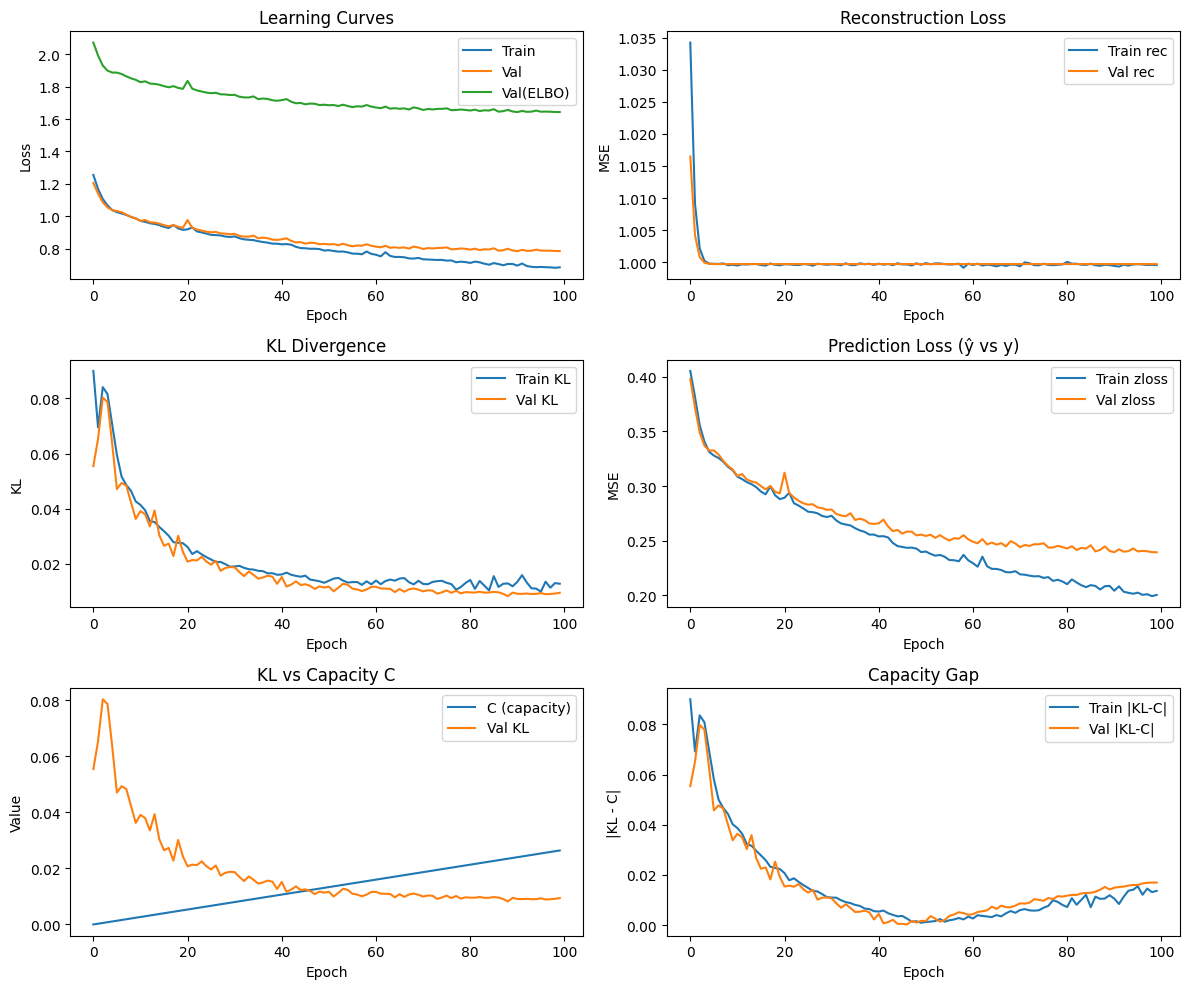

In [17]:
plot_all_curves(
    train_hist,
    val_hist,
    elbo_val_hist,
    train_rec_hist,
    val_rec_hist,
    train_kl_hist,
    val_kl_hist,
    train_z_hist,
    val_z_hist,
    C_values,
    train_capgap_hist,
    val_capgap_hist,
)

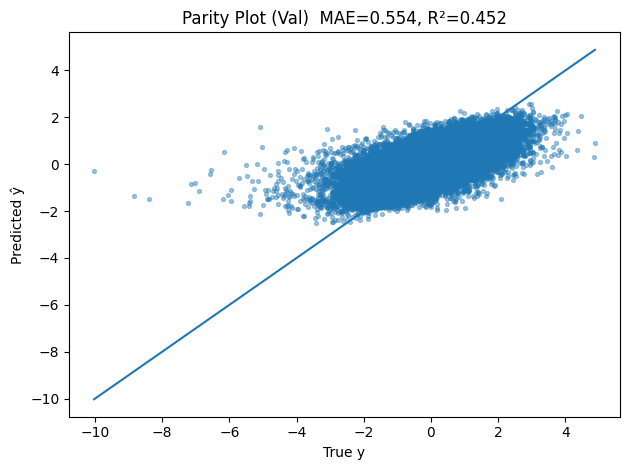

In [18]:
state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()  # 評価モード

eval_dl = torch.utils.data.DataLoader(
    val_ds,  # 元の val_ds でOK
    batch_size=8192,  # 好きなサイズ
    shuffle=False,
    num_workers=0,  # ★シングルプロセス
    pin_memory=False,  # ★不要
    persistent_workers=False,  # ★絶対 False
    drop_last=False,
)

ys, yhats = [], []
with torch.inference_mode():
    for xg, xd, y in eval_dl:
        xg, xd = xg.to(device), xd.to(device)
        _, _, _, yhat = model(xg, xd)
        ys.append(y.cpu().numpy())
        yhats.append(yhat.cpu().numpy())
ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
mae = mean_absolute_error(ys, yhats)
r2 = r2_score(ys, yhats)

plt.figure()
plt.scatter(ys, yhats, s=8, alpha=0.4)
lims = [min(ys.min(), yhats.min()), max(ys.max(), yhats.max())]
plt.plot(lims, lims)
plt.xlabel("True y")
plt.ylabel("Predicted ŷ")
plt.title(f"Parity Plot (Val)  MAE={mae:.3f}, R²={r2:.3f}")
plt.tight_layout()
plt.show()

# How to eval from loading the model

In [19]:
# # 1. Build the model and load the trained weights
# model = GeneDrugVAE(gene_dim, drug_dim=768, proj_dim=256, hidden=512, latent=128).to(device)
# model.load_state_dict(torch.load("models/gdsc/gdsc_last.pt", map_location=device))
# model.eval()  # set to evaluation mode

# # 2. Extract latent representations (μ) for all samples
# mus = []
# with torch.no_grad():  # disable gradient computation
#     for xg, xd, _ in dl:   # ignore y (IC50), only need xg and xd
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, lv = model.encode(xg, xd)   # encode gene + drug into latent space
#         mus.append(mu.cpu().numpy())    # collect μ on CPU

# # Concatenate all latent vectors into one array
# Z_mu = np.concatenate(mus, axis=0)
# print("Latent shape:", Z_mu.shape)

In [20]:
# # ---------- 1) 全サンプルの μ をバッチで抽出 ----------
# model.eval()
# mus = []
# with torch.no_grad():
#     # 推論用 DataLoader（shuffle=False）
#     infer_dl = DataLoader(ds, batch_size=8192, shuffle=False, num_workers=0)
#     for xg, xd, y in tqdm(infer_dl, desc="Encode (μ)", leave=False):
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, logvar = model.encode(xg, xd)  # GeneDrugVAE で encode を実装している前提
#         mus.append(mu.cpu().numpy())

# Z_mu = np.concatenate(mus, axis=0)  # (N, latent)

In [21]:
# # 可視化用メタ：薬ラベル & Z_score（元の ds に対応する順序を確保）
# # cellline_small の順序が ds と一致している前提（Dataset 内でそのまま index を使っている実装ならOK）
# meta_df = cellline_small.reset_index(drop=True).copy()
# # NAME が無い場合は SMILES を代用
# drug_label = meta_df["NAME"] if "NAME" in meta_df.columns else meta_df["SMILES"]
# zscore = meta_df["Z_score"].values
# cellline = meta_df["COSMIC_ID"]

In [22]:
# X0 = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_mu)
# X = (
#     PCA(n_components=min(100, X0.shape[1]), random_state=42)
#     .fit_transform(X0)
#     .astype("float32")
# )

# umap2d = umap.UMAP(
#     n_neighbors=40,
#     min_dist=0.05,
#     metric="cosine",
#     init="spectral",
#     densmap=True,
#     random_state=42,
#     low_memory=True,
#     verbose=True,
# ).fit_transform(X)

In [23]:
# plt.figure()
# sc = plt.scatter(umap2d[:, 0], umap2d[:, 1], s=6, c=zscore, alpha=0.7)
# cb = plt.colorbar(sc)
# cb.set_label("Z_score")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP colored by Z_score")
# plt.tight_layout()
# plt.show()

In [24]:
# # 入力: umap2d (N,2), drug_label (N,), zscore (N,)
# labs = pd.Series(drug_label).astype(str).str.strip().values
# z = np.asarray(zscore, dtype=float)

# # 座標で集約（丸めて同一点判定）
# xy = np.round(umap2d, 6)
# df = pd.DataFrame({"x": xy[:, 0], "y": xy[:, 1], "drug": labs, "z": z})

# # 各座標で「z が最小の薬」を代表に採用（効きが強い薬）
# idx = df.groupby(["x", "y"])["z"].idxmin()
# rep = df.loc[idx].reset_index(drop=True)  # x,y,drug,z が 1行/座標

# # 可視化（Top-20 + Other）
# vc = rep["drug"].value_counts()
# top_k = 20
# top = list(vc.head(top_k).index)

# cmap = plt.colormaps.get_cmap("tab20")
# colors = {d: cmap(i / (top_k - 1)) for i, d in enumerate(top)}
# other_color = (0.5, 0.5, 0.5, 0.25)

# plt.figure(figsize=(9, 7))
# # Otherを下地に
# m_other = ~rep["drug"].isin(top)
# plt.scatter(
#     rep.loc[m_other, "x"],
#     rep.loc[m_other, "y"],
#     s=6,
#     alpha=0.30,
#     color=other_color,
#     rasterized=True,
#     zorder=1,
#     label="Other",
#     edgecolors="none",
# )
# # Top-20 を重ねる
# for d in top:
#     m = rep["drug"].values == d
#     if m.any():
#         plt.scatter(
#             rep.loc[m, "x"],
#             rep.loc[m, "y"],
#             s=12,
#             alpha=0.95,
#             color=colors[d],
#             label=d,
#             rasterized=True,
#             zorder=3,
#             edgecolors="none",
#         )

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP – winner-takes-all by drug (min Z_score)")
# plt.legend(
#     bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=2
# )
# plt.tight_layout()
# plt.show()

In [25]:
# labs = pd.Series(drug_label).astype(str).str.strip().values
# drug = "Cisplatin"  # 例

# m = labs == drug
# plt.figure(figsize=(7, 6))
# plt.hexbin(umap2d[m, 0], umap2d[m, 1], gridsize=80, mincnt=1, norm=LogNorm())
# cb = plt.colorbar()
# cb.set_label("count (log)")
# plt.title(f"UMAP density – {drug}")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()